In [1]:
import os
import glob
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

In [2]:
# File paths for your CSV files
file_paths = [
    'AEM_WELL_LITHOLOGY_csv_WO4_20230831.csv',
    'AEM_WELL_LITHOLOGY_csv_WO5_20230125.csv',
    'AEM_WELL_LITHOLOGY_csv_WO6_20230103.csv',
    'AEM_WELL_LITHOLOGY_csv_WO7_20230327.csv',
]

In [3]:
# List to hold dataframes
dataframes = []

# Read each CSV file and append to the list
for file_path in file_paths:
    try:
        # Attempt to read with default encoding
        df = pd.read_csv(file_path)
        dataframes.append(df)
    except UnicodeDecodeError:
        try:
            # Try reading with a different encoding if the first attempt fails
            df = pd.read_csv(file_path, encoding='latin1')
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {file_path}")
    except pd.errors.ParserError:
        print(f"Error parsing file: {file_path}")

# Concatenate all dataframes
if dataframes:
    merged_df = pd.concat(dataframes, ignore_index=True)
    print(merged_df)
else:
    print("No dataframes to merge.")

C:\Users\betebari\AppData\Local\Temp\ipykernel_24560\2185420019.py:8: DtypeWarning: Columns (2,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\betebari\AppData\Local\Temp\ipykernel_24560\2185420019.py:8: DtypeWarning: Columns (2,15,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\betebari\AppData\Local\Temp\ipykernel_24560\2185420019.py:13: DtypeWarning: Columns (3,4,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='latin1')
C:\Users\betebari\AppData\Local\Temp\ipykernel_24560\2185420019.py:8: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


        LITH_ID  WELL_INFO_ID LOCAL_ID1 LOCAL_ID2  \
0         46615             1       NaN    8841.0   
1         46616             1       NaN    8841.0   
2         46617             1       NaN    8841.0   
3         46618             1       NaN    8841.0   
4         46619             1       NaN    8841.0   
...         ...           ...       ...       ...   
679116   122099         12022       NaN       NaN   
679117   122100         12022       NaN       NaN   
679118   122101         12022       NaN       NaN   
679119   122102         12022       NaN       NaN   
679120   122103         12022       NaN       NaN   

                             LOCAL_ID3  X_CATEALEALBERS_m  Y_CATEALEALBERS_m  \
0                                  NaN        46235.86635       -314240.5205   
1                                  NaN        46235.86635       -314240.5205   
2                                  NaN        46235.86635       -314240.5205   
3                                  NaN     

In [4]:
# Rename the columns
merged_df = merged_df.rename(columns={
    'GROUND_SURFACE_ELEVATION_m': 'GSE_m',
    'LITH_TOP_DEPTH_m': 'INTERVALSTART_m',
    'LITH_BOT_DEPTH_m': 'INTERVALEND_m',
    'WELL_INFO_ID' : 'WCRNUMBER'
})

# Display the resulting dataframe

In [5]:
# Unit Conversion meters to feet

merged_df['GSE_ft'] = merged_df['GSE_m'] * 3.28084
merged_df['INTERVALSTART'] = merged_df['INTERVALSTART_m'] * 3.28084
merged_df['INTERVALEND'] = merged_df['INTERVALEND_m'] * 3.28084

In [6]:
# Drop specified columns
merged_df = merged_df.drop(columns=['GSE_m','INTERVALSTART_m', 'INTERVALEND_m'])

In [7]:
# Drop columns that are no longer needed
merged_df.drop(columns=['LOCAL_ID3', 'LITH_MAJOR1', 'LITH_MAJOR2' ,'LITH_MINOR1','USCS_DESCRIPTION' ,
            'RAW_DESCRIPTION', 'DATA_SOURCE' , 'DESCRIPTOR', 'QAQC','USCS_SYMBOL','LITH_MINOR2',
            'TEXTURE', 'TEXTURE_REFINED' , 'COLOR', 'NOTES'], inplace=True)
                            
# Convert DataFrame to GeoDataFrame
merged_df = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df['X_CATEALEALBERS_m'], merged_df['Y_CATEALEALBERS_m']),
    crs="EPSG:3310"  # Original CRS
)

# WCR's locations 2 shapefile
merged_df.to_file('AEM_supp.shp', driver='ESRI Shapefile')

C:\Users\betebari\AppData\Local\Temp\ipykernel_24560\1612540081.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_df.to_file('AEM_supp.shp', driver='ESRI Shapefile')


<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

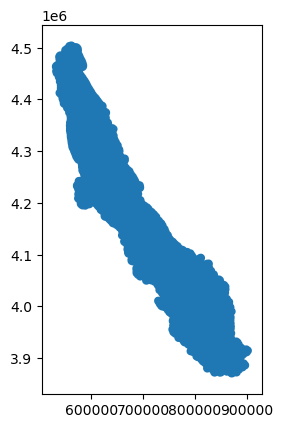

In [8]:
aquifer_boundary = gpd.read_file('central_val_buf_5mil_utm10n.shp')
aquifer_boundary.plot()
aquifer_boundary.crs

In [9]:
# Reproject to EPSG:26910
gdf_Ramboll = merged_df.to_crs("EPSG:26910")

# Extract UTM X and Y coordinates from the geometry column
gdf_Ramboll['UTMX'] = gdf_Ramboll.geometry.x
gdf_Ramboll['UTMY'] = gdf_Ramboll.geometry.y

# Save or use the reprojected GeoDataFrame
print(gdf_Ramboll)

# Optionally save the reprojected GeoDataFrame to a new file
gdf_Ramboll.to_file("reprojected_AEM_supporting.shp")

        LITH_ID  WCRNUMBER LOCAL_ID1 LOCAL_ID2  X_CATEALEALBERS_m  \
0         46615          1       NaN    8841.0        46235.86635   
1         46616          1       NaN    8841.0        46235.86635   
2         46617          1       NaN    8841.0        46235.86635   
3         46618          1       NaN    8841.0        46235.86635   
4         46619          1       NaN    8841.0        46235.86635   
...         ...        ...       ...       ...                ...   
679116   122099      12022       NaN       NaN      -172051.02680   
679117   122100      12022       NaN       NaN      -172051.02680   
679118   122101      12022       NaN       NaN      -172051.02680   
679119   122102      12022       NaN       NaN      -172051.02680   
679120   122103      12022       NaN       NaN      -172051.02680   

        Y_CATEALEALBERS_m                     LITH_TRANSCRIPTION      GSE_ft  \
0            -314240.5205                            Yellow Clay  927.580030   
1          

C:\Users\betebari\AppData\Local\Temp\ipykernel_24560\1831986779.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_Ramboll.to_file("reprojected_AEM_supporting.shp")


In [10]:
clipped_points = gpd.clip(gdf_Ramboll, aquifer_boundary)
print(clipped_points.shape)
print(clipped_points.head())

(658686, 13)
       LITH_ID  WCRNUMBER LOCAL_ID1 LOCAL_ID2  X_CATEALEALBERS_m  \
92389   217727      18926       NaN       NaN         104444.274   
92367   217705      18926       NaN       NaN         104444.274   
92398   217736      18926       NaN       NaN         104444.274   
92397   217735      18926       NaN       NaN         104444.274   
92396   217734      18926       NaN       NaN         104444.274   

       Y_CATEALEALBERS_m                    LITH_TRANSCRIPTION      GSE_ft  \
92389       -337114.7239                       clay and gravel  959.850031   
92367       -337114.7239                  sand with brown clay  959.850031   
92398       -337114.7239  clay and gravel, yellow-orange-brown  959.850031   
92397       -337114.7239                                  sand  959.850031   
92396       -337114.7239                       shale interbeds  959.850031   

       INTERVALSTART  INTERVALEND                        geometry  \
92389     150.000005   210.000007  POINT

In [11]:
clipped_points.to_file("clipped_gdf_Ramboll.shp")

C:\Users\betebari\AppData\Local\Temp\ipykernel_24560\560966907.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_points.to_file("clipped_gdf_Ramboll.shp")


In [ ]:
# Drop columns that are no longer needed
clipped_points.drop(columns=['X_CATEALEALBERS_m','Y_CATEALEALBERS_m' ,
                      'LOCAL_ID1', 'LOCAL_ID2' , 'LITH_ID' , 
                       ], inplace=True)

# Rename the columns
clipped_points = clipped_points.rename(columns={
    'WELL_INFO_ID': 'WCRNUMBER',
    'LITH_TRANSCRIPTION' : 'DESCRIPTION',})

# Get the number of unique values in the 'WCRNUMBER' column
unique_wcrnumber_count = clipped_points['WCRNUMBER'].nunique()
print(f"Number of unique WCRNUMBER values: {unique_wcrnumber_count}")
clipped_points.plot()
clipped_points.head()
# Display the resulting dataframe

C:\Users\betebari\AppData\Local\Temp\ipykernel_24560\2310271036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clipped_points.drop(columns=['X_CATEALEALBERS_m','Y_CATEALEALBERS_m' ,


Number of unique WCRNUMBER values: 16899


In [ ]:
import re
# Define USCS codes and their associated keywords
uscs_codes = [
    'ML', 'GP', 'SP-SM', 'GC', 'CL', 'CH', 'MH', 'GP-GM', 'PT',
    'GP-GC', 'GM', 'ml','OL','OL/OH' 'SP-SM', 'SC-SM', 'CH', 'SC','SW','SC', 'MH',
    'SM-SC', 'SM-ML', 'SM-GP', 'SP-GP', 'SW-GW', 'SC-GC', 'SC-ML', 'SP/GP/CL', 'CL/SP',
    'GW-GM', 'OH/CH', 'CL/CH', 'Cl', 'SW-SM', 'SW-SC', 'SP-SM', 'SP-SC', 'OL', 'GW-GC', 'GP-SP',
    'GP-GM', 'GP-GC', 'GP-CG', 'CL-ML', 'CH+GP', 'SM/GM', 'sm/ml/sm/cl', 'sm/ml/sm/ml', 'sm/ml/sp/ml',
    'SM>ML>CL', 'SM>ML>SP>CL>SM', 'SM>ML,SP>SC>CL', 'PT.','PT', 'sm', 'sw', 'sp', 'ml', 'sc', 'cl', 'ch', 'mh', 'gp', 'gc',
    'sm/sp/ml', 'sp-sm', 'cl-ml', 'ch+gp', 'sm/ml', 'sm/sp', 'sm/sp/ml',
]

#Identify the USCS keyterms in the description
descrip = clipped_points.DESCRIPTION.astype(str)
pattern = r'\b(?:' + '|'.join(map(re.escape, uscs_codes)) + r')\b'
extracted_uscs = [re.findall(pattern,d,re.IGNORECASE) for d in descrip]
clipped_points['USCS_keys']= extracted_uscs

keys = clipped_points['USCS_keys']
separator = ','
d = []
for key in keys:
    comb = separator.join(key)
    d.append(comb)
clipped_points.USCS_keys = d


In [ ]:
keywords_keep = {
    # Compound soil types
    'gravelly clay', 'sandy loam', 'silty clay', 'pebbly loam', 'cobbly sand', 'sandy mud','dg',
    'clayey loam', 'sandy clay', 'silty loam', 'gravelly sand', 'pebbley sand','clayey wood',
    'cobbley clay', 'loamy sand', 'clayey gravel', 'gravelly loam', 'pebbley clay','gravelly wood',
    'sandy gravel', 'clayey sand', 'silty gravel', 'loamy gravel', 'silty sand','mucky mud',
    'gravelly silt', 'pebbley gravel', 'cobbley loam', 'clayey silt', 'gravelly clayey sand',
    'loamy clay', 'pebbley loamy', 'sandy silty', 'cobbley gravel', 'clayey sandy','cobbley sandy pebbles',
    'silty cobbly', 'gravelly pebbly', 'sandy cobble', 'gravelly sandy','gravelly cobbles','cobbley sandy pebbles',
    'rocky clay', 'rocky loam', 'rocky gravel', 'rocky silt','rocky sand','gravelly boulders','cobbley gravelly wood',
    'cobbley gravelly pebbles',
    # Sedimentary rocks
    'sandstone', 'conglomerate', 'shale', 'siltstone', 'limestone', 'cobblestone',  'mudstone', 'claystone',
    
    # Soil classifications
    'silt', 'sand', 'gravel',  'clay', 'boulder', 'loam', 'cobble', 'gravels','cobbles','boulders','clays','mud', 'wood',
    'pebbles','hardpan', 

    # Soil descriptors
    'sticky clay', 'fat clay', 'lean clay', 'hardpan','pan', 'organic', 'adobe',  'weathered','poorly graded sand', 'well graded sand',
    'poorly graded gravel', 'well graded gravel',
    # Rocks and minerals
    'basalt', 'basaltic', 'pumice', 'latite', 'volcanics', 'volcanic', 'cinder','cinders', 'ash', 'lime','fault breccia',
    'tufa', 'tuff', 'lava', 'rhyolite', 'granite', 'diorite', 'quartz', 'gabbro', 'quartzite', 
    'granodiorite', 'igneous', 'andesite', 'greenstone', 'slate', 'schist', 'serpentine', 'mudstone',
    'metasediment', 'phyllite', 'argillite', 'bluestone', 'soapstone', 'chert','fractured','fracture',
    'fractured rock', 'gouge', 'hardrock', 'rock','bedrock','frac','tuscan','lapilli','limestone',

    # Other geological terms
    'sediment', 'alluvium', 'loam', 'peat', 'organics','topsoil','soil', 'organic'
}

In [ ]:
# Select only the key words to convert into USCS
descrip = clipped_points['DESCRIPTION']

# Build the regex pattern
pattern = r'\b(?:' + '|'.join(map(re.escape, keywords_keep)) + r')\b'

# Apply the regex, handling NaN values by converting them to an empty string
extracted_words = [re.findall(pattern, str(d), re.IGNORECASE) for d in descrip]

# Add the extracted words as a new column
clipped_points['KEYWORDS_LIST'] = extracted_words

# Join the keywords into a single string
new_descriptions = clipped_points['KEYWORDS_LIST']
separator = ' ,'
d = []

for new_description in new_descriptions:
    new_descrip = separator.join(new_description)
    d.append(new_descrip.lower())

# Add the final keywords column
clipped_points['KEYWORDS'] = d

# Drop the intermediate column
clipped_points = clipped_points.drop(['KEYWORDS_LIST'], axis=1)

# Display the updated DataFrame
clipped_points.head()

In [ ]:
# Updated dictionary to map keywords into USCS codes including terms from uscs_keywords_keep
uscs_keywords = { 
    'gravelly sand': 'SW',
    'topsoil': 'OH',
    'top soil': 'OH',
    'shale': 'SHLE',
    'clayey gravel': 'GC',
    'clay ,gravel': 'GC',
    'gravelly shale': 'CL',
    'clay': 'CH',
    'sandy clay': 'CL',
    'sand': 'SW',
    'silty clay': 'CL',
    'bouldery gravel': 'GP',
    'gravel': 'GP',
    'clayey sand': 'SC',
    'sand ,clay': 'SC',
    'clayey top soil': 'OH-CH',
    'sandstone': 'SDST',
    'sandy silt': 'ML',
    'rock': 'ROCK',
    'hard pan': 'ML',
    'pan': 'ML',
    'muddy sand': 'SC',
    'sandy top soil': 'OH-SP',
    'sandy gravel': 'GW',
    'gravelly cobbles': 'GP',
    'gravelly sandstone': 'SDST,GP',
    'rocky clay': 'GC',
    'pebbley gravel': 'GW',
    'pebbley sand': 'SW-GW',
    'clay': 'CH',
    'silt': 'ML',
    'gravelly  sand':'SP-GW', 
    'gravelly sand':'SP-GW',  
    'rocky sand': 'SP-GP',
    'sandy hard pan':'ML',
    'pebbley clay':'GC' ,
    'shaley silt': 'ML',
    'sandy rock': 'ROCK, SP',
    'sticky clay': 'CH',
    'rocky gravel': 'GW',
    'shaley sand': 'SC',
    'fill': 'unknown',
    
    'sandy clay':'CL' ,
    'clayey shale': 'SHLE,CL',
    'clayey shale': 'SHLE,CL',
    'sandy shale': 'SHLE,SC',
    'pebbles': 'PEBL',
    'silty sand': 'SM',
    'loam': 'SM',
    'loamy': 'SM',
    'silty top soil': 'OH',
    'wood': 'PT',
    'bouldery clay': 'GC',
    'conglomerate': 'CONG',
    'bouldery sand':'SP-GP' ,
    'boulders': 'GW',
    'gravelly mud': 'GC',
    'bouldery rock': 'CONG',
    'shells': 'GP-SP',
    
    'shelly sand': 'SW-SC',
    'shaley clay': 'CL',
    'cobbles': 'GW',
    'cobble': 'GW',
    'other': 'unknown',
    
    'bouldery hard pan': 'ML-GP',
    'gravelly boulders': 'GP',
    'cobbley sand': 'SP-GP',
    'shaley gravel': 'GC' ,
    'sandy siltstone': 'STST, SP',
    'siltstone': 'STST',
    'gravelly siltstone': 'STST,GM',
    'clayey siltstone': 'STST,CL',
    'clayey silt': 'ML',
    'claystone/sand': 'CLSN,SC',
    'silty claystone': 'CLSN,ML',
    'sandy claystone': 'CLSN,SC',
    'silty sandstone': 'SDST,ML',
    'silty ash': 'ASH,ML',
    
    'cobbley clay': 'GC',
    'clayey rock': 'ROCK,CL',
    'silty gravel': 'GM',
    'gravelly rock': 'CONG',
    'gravelly silt': 'ML', 
    'gravelly clay': 'GC',
    'sandy ash': 'SP',
    
    'coarse sand': 'SP',
    'pebbley cobbles': 'GP',
    'lava': 'LAVA',
    'sand': 'SW',
    'soil': 'OH' ,
    'mud': 'CH' ,
    'peat':'PT',
    'shaley rock': 'SHLE',
    'sandstone clay': 'SDST,CLSN',
    'rocky sandstone': 'SDST,CONG',
    'silty cobbles': 'GM',
    'ash': 'ASH',
    'sandy sand': 'SW',
    'rocky conglomerate': 'CONG',
    'gravelly gravel':'GW',
    'sandy conglomerate': 'CONG,SDST',
    'gravelly conglomerate': 'CONG',
    'shaley sandstone': 'SDST,SHLE',
    'rocky shale': 'SHLE,ROCK',
    'cobbley gravel':'GW',
    'muddy siltstone': 'STST,CLSN',
    'clayey sandstone': 'SDST,SC',
    'clayey ash': 'ASH,CL',
    'clayey sanstone': 'SDST,CLSN',
    'gravelly sanstone': 'SDST,CONG',
    'sandy boulders':'GP-SP',
    'claystone': 'CLSN',
    'clayey clay': 'CH',
    'silty  sand': 'SM',
    'gravelly claystone': 'CLSN,GC',
    'sandy gravel':'GP-SP', 

    # Sedimentary rocks
    'conglomerate': 'CONG',
    'cobblestone': 'CONG',
    'graywacke|sandstone': 'SDST',
    'shale': 'SHLE',
    'claystone|mudstone': 'CLSN',
    'siltstone': 'STST',

    # Soil classifications
    'silt': 'ML', 'sand': 'SP', 'gravel': 'GP', 'clay': 'CL', 'boulder|cobble': 'COBL',    'Soil or Organic': 'TPSL, OH',

    # Soil descriptors
    'sticky clay': 'CH', 'fat clay': 'CH', 'lean clay': 'CL', 'hardpan': 'ML', 'organic': 'OH',
    'adobe': 'CH', 'weathered': 'SW-GW', 'poorly graded gravel': 'GP', 'well graded gravel': 'GW',
    'poorly graded sand': 'SP', 'well graded sand': 'SW',
    
    # Rocks and minerals
    'basalt|basaltic': 'BSLT',
    'pumice|lapilli|tuscan': 'VFRG',
    'volcanic|volcanics':'VOLC',
    'limestone|lime stone':'LMST',
    'cinder|ash|tufa|tuff' : 'TUFF',
    'lava': 'LAVA', 'granite': 'GRNT','granodiorite': 'GRNT', 'diorite|quartz|gabbro|quartzite': 'IGNS',
    'rhyolite|andesite|latite|igneous': 'IGNS', 'greenstone|serpentine|phyllite|argillite': 'META',
    'metasediment': 'META', 'bluestone|soapstone': 'META', 'slate': 'SCHT', 'schist': 'SCHT',
    'chert': 'SDST', 'fractured|fractured rock|gouge|hardrock|rock|bedrock|frac': 'FRAC','dg': 'DGRNT',
    
    # Other geological terms
    'sediment|alluvium': 'GW-SW',
    'topsoil|soil': 'TPSL',
}


In [ ]:
# Function to process each row in the 'KEYWORDS' column
def extract_uscs_classifications(keywords, uscs_dict):
    # Split the keywords on commas and remove leading/trailing whitespace
    keyword_list = [kw.strip() for kw in keywords.split(',')]
    
    # Match each keyword to its corresponding USCS classification
    classifications = [uscs_dict[kw] for kw in keyword_list if kw in uscs_dict]
    
    # Join classifications with commas
    return ', '.join(classifications)

In [ ]:
# Apply the updated logic
clipped_points['USCS'] = clipped_points['KEYWORDS'].apply(lambda x: extract_uscs_classifications(x, uscs_keywords))

# Display the resulting DataFrame
print(clipped_points)

In [ ]:
# Filter rows where 'USCS_keys' is not NaN and not an empty string
df_na = clipped_points[clipped_points['USCS_keys'].notna() & (clipped_points['USCS_keys'] != '')]

# Use .loc[] to explicitly assign values to the 'USCS' column
df_na.loc[:, 'USCS'] = df_na['USCS_keys']

# Update the original DataFrame with the modified 'df_na'
clipped_points.update(df_na)

# Identify and display any unmatched values
unmatched_values = clipped_points[clipped_points['USCS'].isna()]['USCS_keys'].unique()
print("Unmatched 'USCS' values:", unmatched_values)

# Display the updated DataFrame
clipped_points.head()

In [ ]:
import re
# Load the provided Excel file
file_path = r'C:\Users\betebari\Documents\C2VSim_Texture\OSWCR\USCS-averageKxy-CoarseFractions.xlsx'
excel_data = pd.read_excel(file_path)

# Strip leading/trailing spaces and convert to lowercase in 'Sediment/Rock Type' for consistency
excel_data['Sediment/Rock Type'] = excel_data['Sediment/Rock Type'].str.strip().str.lower()

# Create a dictionary mapping Soil Classification to Average Hydraulic Conductivity
hydraulic_conductivity_mapping = dict(zip(excel_data['Sediment/Rock Type'], excel_data['Average Hydraulic Conductivity (ft/day)']))

# Create a dictionary mapping Soil Classification to Average Coarse Fraction
coarse_fraction_mapping = dict(zip(excel_data['Sediment/Rock Type'], excel_data['Average Coarse Fraction (%)']))

# Create separate mappings for Specific Yield, Ss, and Kv based on the Excel data columns
specific_yield_mapping = dict(zip(excel_data['Sediment/Rock Type'], excel_data['Avg Specific Yield (%)']))
ss_mapping = dict(zip(excel_data['Sediment/Rock Type'], excel_data['Avg Ss (1/L)']))
kv_mapping = dict(zip(excel_data['Sediment/Rock Type'], excel_data['Avg Kv (ft/day)']))

# Clean the 'USCS' column in the merged DataFrame
clipped_points['USCS'] = clipped_points['USCS'].str.strip().str.replace(r'[\(\)]', '', regex=True).str.lower()

def aggregate_uscs_values(uscs_value, mapping, agg_func='average'):
    # Handle NaN or non-string values
    if pd.isna(uscs_value) or not isinstance(uscs_value, str):
        return None  # You can replace None with a default value if needed

    # Handle 'unknown' case
    if 'unknown' in uscs_value:
        return None  # Replace None with a default value, e.g., 0

    # Corrected regex to handle different separators
    uscs_classes = re.split(r'[,&/]', uscs_value)  # Adjust splitting for multiple separators

    # Extract values based on mapping and apply the aggregation function
    mapped_values = [mapping.get(uscs.strip()) for uscs in uscs_classes if uscs.strip() in mapping]

    # Special case handling for 'gc-gm' and 'sc-sm'
    if uscs_value in ['gc-gm', 'sc-sm']:
        gc_value = mapping.get('gc', None)
        gm_value = mapping.get('gm', None)
        sc_value = mapping.get('sc', None)
        sm_value = mapping.get('sm', None)

        # Example logic: calculate average for 'gc-gm' or 'sc-sm'
        if uscs_value == 'gc-gm':
            mapped_values = [gc_value, gm_value]
        elif uscs_value == 'sc-sm':
            mapped_values = [sc_value, sm_value]

        # Remove None values if any are missing
        mapped_values = [val for val in mapped_values if val is not None]

    # If no valid mappings are found, return None
    if not mapped_values:
        return None  # Or return a default value if no valid class is found

    # Apply the chosen aggregation function (average, max, or min)
    if agg_func == 'average':
        return sum(mapped_values) / len(mapped_values)
    elif agg_func == 'max':
        return max(mapped_values)
    elif agg_func == 'min':
        return min(mapped_values)
    
    return None  # Default return if no valid aggregation function matches


# Apply the enhanced function for Hydraulic Conductivity and Coarse Fraction
clipped_points['HydraulicConductivity'] = clipped_points['USCS'].apply(lambda x: aggregate_uscs_values(x, hydraulic_conductivity_mapping, agg_func='average'))
clipped_points['AverageCoarseFraction'] = clipped_points['USCS'].apply(lambda x: aggregate_uscs_values(x, coarse_fraction_mapping, agg_func='average'))
clipped_points['Avg Specific Yield (%)'] = clipped_points['USCS'].apply(lambda x: aggregate_uscs_values(x, specific_yield_mapping, agg_func='average'))
clipped_points['Avg Ss (1/L)'] = clipped_points['USCS'].apply(lambda x: aggregate_uscs_values(x, ss_mapping, agg_func='average'))
clipped_points['Avg Kv (ft/day)'] = clipped_points['USCS'].apply(lambda x: aggregate_uscs_values(x, kv_mapping, agg_func='average'))

# Check for remaining unmatched values
unmatched_values = clipped_points[clipped_points['HydraulicConductivity'].isna()]['USCS'].unique()
print("Remaining unmatched 'USCS' values:", unmatched_values)

In [ ]:
# Drop specified columns
clipped_points = clipped_points.drop(columns=['geometry','USCS_keys'])

# Convert the 'USCS' column to uppercase
clipped_points['USCS'] = clipped_points['USCS'].str.upper()


In [ ]:
# Save the updated DataFrame to a new CSV file
output_file = '6-updated_Ramboll_WCRs.csv'
clipped_points.to_csv(output_file, index=False)

print(f"Updated CSV file saved as '{output_file}'")